<h1>Digit classification with CNN</h1> 


<h5>In this notebook we will used a custom CNN to classify handwritten digits from the MNIST database</h5>

<h2>Imports</h2>


In [1]:
!pip install torchvision==0.9.1 torch==1.8.1 
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt

The function <code>plot_channels</code> will be used to plot the kernel parameters of each channel

In [2]:
def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0

    # plot outputs as rows inputs as columns
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

The function <code>plot_parameters</code> will plot out the kernel parameters of each channel with multiple outputs

In [3]:
def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            ax.set_xlabel("kernel:{0}".format(i + 1))
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)
    plt.show()

The function <code>plot_activation</code> will plot out the activations of the Convolutional layers

In [4]:
# Define the function for plotting the activations
def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

The function <code>show_data</code> will plot out data samples as images

In [29]:
def show_data(data_sample):
    plt.figure(figsize=(3, 3))
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))
    plt.show()

<h2 id="Makeup_Data">Getting the data</h2> 


We create a transform object to convert the images into tensors, where each image has a size of 28x28

In [6]:
IMAGE_SIZE = 28
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

We can see the data type is int, where each element in the rectangular tensor represents a pixel intensity value

In [7]:
type(train_dataset[0][1])

int

Let's print out multiple samples at random from the training data

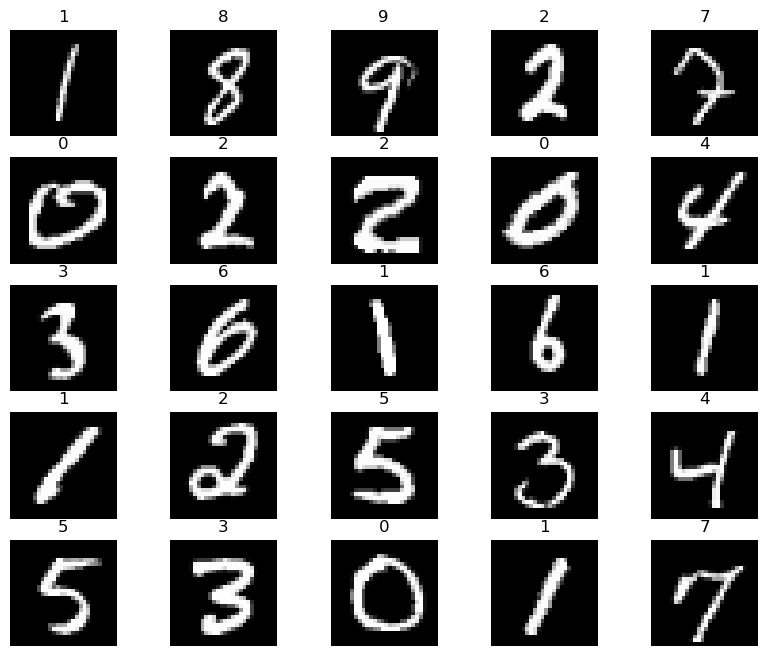

In [8]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

<h2 id="CNN">Building the CNN Class</h2>


The following class defines a CNN with 2 convolutional layers and 1 fully connected layer, and receives as parameters the number of output channels for the 1st and 2nd layer.
The size of the final output matrix is predetermined.

In [9]:
class CNN(nn.Module):
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 7 * 7, 10)

    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    def activations(self, x):
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)

        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0), -1)
        return z1, a1, z2, a2, out1, out

<h2 id="Define Parameters">Defining model parameters</h2> 

In [10]:
model = CNN(out_1=16, out_2=32)

Lets plot the model parameters for the kernel before training. These are initialized randomly

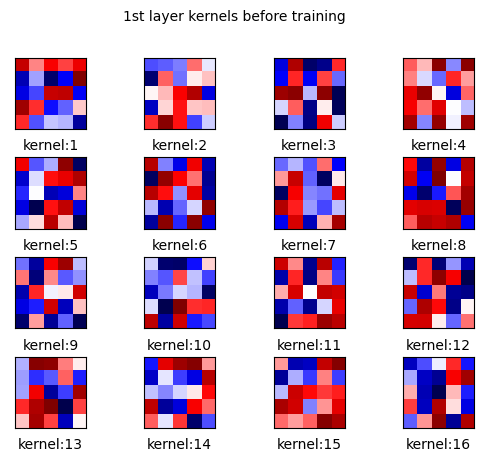

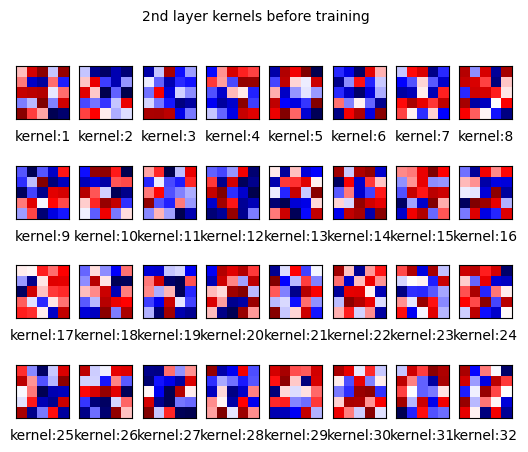

In [11]:
plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

Lets define the loss function (Cross Entropy Loss), the optimizer (Stochastic Gradient Descent), and the dataset loader 


In [12]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=True)

<h2 id = "Train">Training and Evaluation</h2> 

Train the model through 10 epochs and determine validation accuracy

In [13]:
n_epochs = 10
cost_list = []
accuracy_list = []
N_test = len(validation_dataset)


def train_model(n_epochs):
    total_step = len(train_loader)
    for epoch in range(n_epochs):
        COST = 0
        model.train()
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST += loss.data

            if (i+1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                  format(epoch + 1, n_epochs, i + 1, total_step, loss.item()))

        cost_list.append(COST)
        correct = 0
        model.eval()
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)


train_model(n_epochs)

Epoch [1/10], Step [100/600], Loss: 2.0272
Epoch [1/10], Step [200/600], Loss: 0.9261
Epoch [1/10], Step [300/600], Loss: 0.4507
Epoch [1/10], Step [400/600], Loss: 0.3726
Epoch [1/10], Step [500/600], Loss: 0.3940
Epoch [1/10], Step [600/600], Loss: 0.4286
Epoch [2/10], Step [100/600], Loss: 0.5057
Epoch [2/10], Step [200/600], Loss: 0.2603
Epoch [2/10], Step [300/600], Loss: 0.2968
Epoch [2/10], Step [400/600], Loss: 0.2189
Epoch [2/10], Step [500/600], Loss: 0.2642
Epoch [2/10], Step [600/600], Loss: 0.1948
Epoch [3/10], Step [100/600], Loss: 0.2710
Epoch [3/10], Step [200/600], Loss: 0.1630
Epoch [3/10], Step [300/600], Loss: 0.2836
Epoch [3/10], Step [400/600], Loss: 0.1179
Epoch [3/10], Step [500/600], Loss: 0.1962
Epoch [3/10], Step [600/600], Loss: 0.2030
Epoch [4/10], Step [100/600], Loss: 0.1222
Epoch [4/10], Step [200/600], Loss: 0.2348
Epoch [4/10], Step [300/600], Loss: 0.2266
Epoch [4/10], Step [400/600], Loss: 0.2070
Epoch [4/10], Step [500/600], Loss: 0.1317
Epoch [4/10

<h2 id="Result">Analyze Results</h2> 


Plot the total loss and accuracy on the validation data

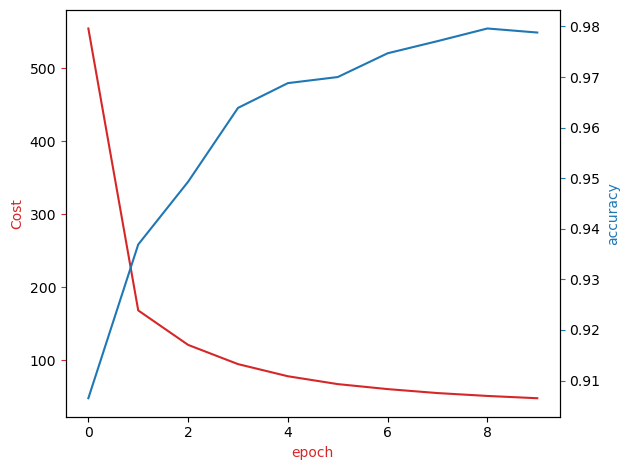

In [14]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.set_xlabel('epoch', color=color)
ax2.plot(accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

Lets view the results of the parameters for the Convolutional layers 

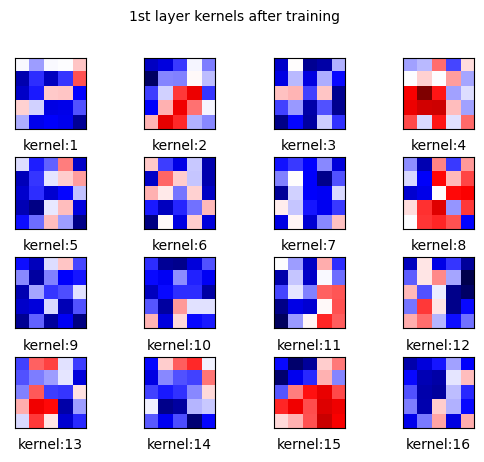

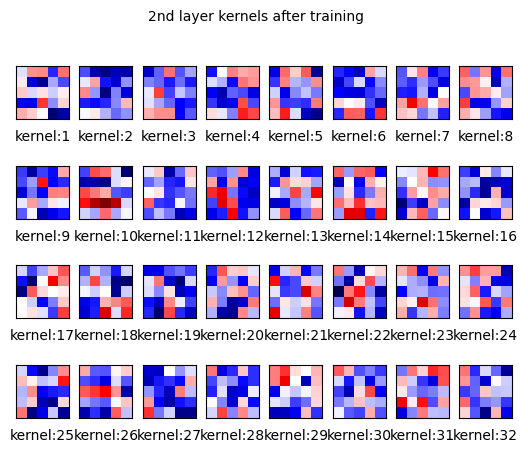

In [15]:
plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels after training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels after training' )

Consider the following sample from the training dataset

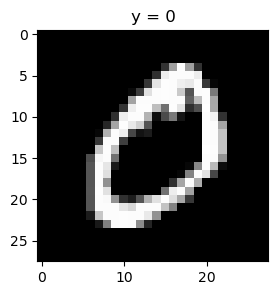

In [30]:
show_data(train_dataset[1])

Lets determine the activations and plot the first set

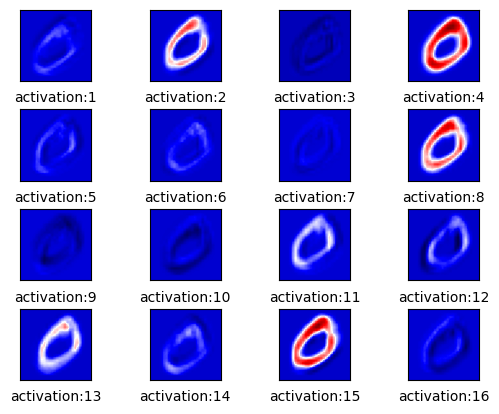

In [17]:
out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))
plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

The image below is the result after applying the relu activation function 

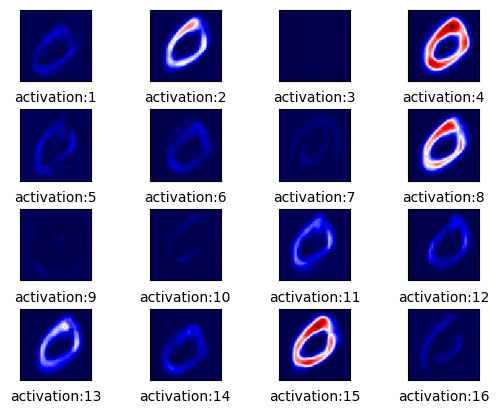

In [18]:
plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

As we can see, the activations resemble the sample being evaluated.

Now lets go ahead and plot the first 4 mis-classified samples

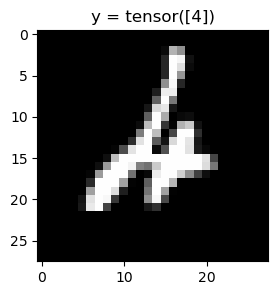

prediction:  tensor([2])


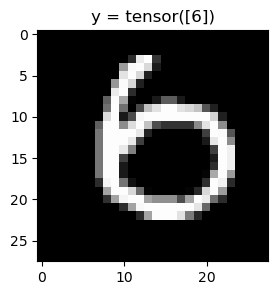

prediction:  tensor([0])


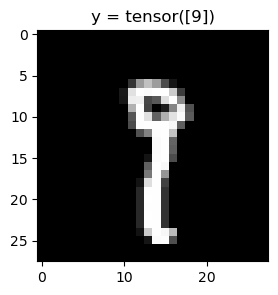

prediction:  tensor([1])


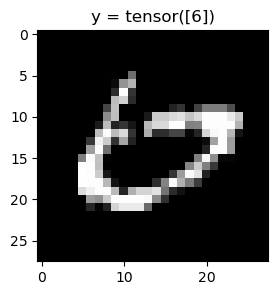

prediction:  tensor([0])


In [31]:
count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        print("prediction: ", yhat)
        count += 1
    if count >= 4:
        break